In [1]:
import pandas as pd
import gpplot
import seaborn as sns
from scipy import stats
import plotnine as gg
import matplotlib.pyplot as plt
from poola import core as pool
import seaborn as sns
import gpplot

In [2]:
def count_elements(seq):
    seqs = {}
    for i in seq:
        seqs[i] = seqs.get(i, 0) + 1
        
    return seqs

In [3]:
horlbeck_may = pd.read_excel("../data/horlbeck_2016_may/elife-12677-supp1-v4.xlsx", sheet_name = 0)

In [4]:
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                            names=['GENE'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                   names=['GENE'])

In [6]:
all_designs = pd.read_table('../../../gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRi_RS3seq-Chen2013_Ensembl_20220808.txt.gz')


In [7]:
len_seq = [len(seq) for seq in horlbeck_may['sgRNA sequence']]
counted = count_elements(len_seq)
counted

{21: 9882, 19: 1687, 20: 5072, 18: 314, 22: 884, 24: 147, 25: 87, 23: 307}

In [8]:
new_seqs = [seq if len(seq) < 20 else seq[len(seq) - 20:len(seq)] for seq in horlbeck_may['sgRNA sequence']]
horlbeck_may['20mer_less'] = new_seqs

In [9]:
mask = horlbeck_may['20mer_less'].str.len() == 19
horlbeck_may_19 = horlbeck_may.loc[mask]
mask = horlbeck_may['20mer_less'].str.len() == 18
horlbeck_may_18 = horlbeck_may.loc[mask]

sg_list = list(horlbeck_may_19['20mer_less'].unique())
all_designs['19mer'] = all_designs['sgRNA Sequence'].str[1:]
design_df_19 = (all_designs[all_designs['19mer'].isin(sg_list)]
             .reset_index(drop=True))

sg_list = list(horlbeck_may_18['20mer_less'].unique())
all_designs['18mer'] = all_designs['sgRNA Sequence'].str[2:]
design_df_18 = (all_designs[all_designs['18mer'].isin(sg_list)]
             .reset_index(drop=True))

In [10]:
design_cols = ['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', "sgRNA 'Cut' Site TSS Offset", 'On-Target Efficacy Score']

In [11]:
lfcs_designs_19 = (horlbeck_may_19.rename({'20mer_less': '19mer'}, axis=1)
                .merge(design_df_19[design_cols + ['19mer', '# Off-Target Tier I Match Bin I Matches']], how='inner',
                       on='19mer')
                .drop('19mer', axis=1))
lfcs_designs_18 = (horlbeck_may_18.rename({'20mer_less': '19mer'}, axis=1)
                .merge(design_df_18[design_cols + ['19mer', '# Off-Target Tier I Match Bin I Matches']], how='inner',
                       on='19mer')
                .drop('19mer', axis=1))
lfcs_designs_20 = (horlbeck_may.rename({'20mer_less': 'sgRNA Sequence'}, axis=1)
                .merge(all_designs[design_cols + ['# Off-Target Tier I Match Bin I Matches']], how='inner',
                       on='sgRNA Sequence'))
horlbeck_may_lfcs_designs = pd.concat([lfcs_designs_18, lfcs_designs_19, lfcs_designs_20])

In [12]:
horlbeck_may_lfcs_designs['Target Gene Symbol'].value_counts()

SNW1        25
NIFK        22
CARF        21
HAUS7       20
TREX2       20
            ..
NCBP2AS2     1
CFAP57       1
TUBB         1
ZNF699       1
CTCF         1
Name: Target Gene Symbol, Length: 1534, dtype: int64

In [21]:
pd.merge(horlbeck_may_lfcs_designs, essential_genes, left_on = 'gene symbol', right_on = 'GENE')

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"FANTOM 5 TSS [Where P1 and P2 are >1kb apart, TSSs were treated separately and sgRNAs assigned to the closest TSS; otherwise, P1P2 indicates all coordinates are related to the P1 TSS]",Position relative to FANTOM5 TSS,Activity score,Target site MNase signal,Doench et al. Nat. Biotech. 2014 sgRNA sequence score,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,sgRNA 'Cut' Site TSS Offset,On-Target Efficacy Score,# Off-Target Tier I Match Bin I Matches,GENE
0,AARS2,chr6,44281044,+,22,GCTACGATGGCAGCGTCAG,P1P2,-1.0,1.247133,0.022727,0.084823,AGCTACGATGGCAGCGTCAG,CCGGAGCTACGATGGCAGCGTCAGTGGCAG,AARS2,23,0.222700,0,AARS2
1,AARS2,chr6,44281006,+,23,GGCTGCGGCGGGCCATTCGA,P1P2,37.0,0.861104,0.095652,0.184485,GGCTGCGGCGGGCCATTCGA,CGGAGGCTGCGGCGGGCCATTCGAAGGTCG,AARS2,61,0.235100,0,AARS2
2,AARS2,chr6,44281056,+,23,GTCACTGCCCGGAGCTACGA,P1P2,-13.0,0.891763,0.086957,0.215028,GTCACTGCCCGGAGCTACGA,TAAAGTCACTGCCCGGAGCTACGATGGCAG,AARS2,11,0.838700,0,AARS2
3,AARS2,chr6,44280804,-,24,GAACTCCGCTCCCTATCAGTA,P1P2,239.0,0.241512,0.441667,0.310206,AACTCCGCTCCCTATCAGTA,CACGAACTCCGCTCCCTATCAGTATGGTTC,AARS2,274,0.412500,0,AARS2
4,AARS2,chr6,44280878,-,23,GCCGCGGGGCCGCACGGAAG,P1P2,165.0,0.771396,0.269565,0.017359,GCCGCGGGGCCGCACGGAAG,GGTCGCCGCGGGGCCGCACGGAAGCGGAGG,AARS2,200,0.004631,0,AARS2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7064,YTHDC1,chr4,69215779,+,24,GGGAGCGGGATTGTTTCGCGC,P1P2,-80.0,0.006932,0.150000,0.659793,GGAGCGGGATTGTTTCGCGC,TTCGGGAGCGGGATTGTTTCGCGCAGGAAG,YTHDC1,-10,-0.151300,0,YTHDC1
7065,YTHDC1,chr4,69215809,+,24,GAACGAAGCGTAAACAGCGCA,P1P2,-110.0,0.089169,0.241667,0.687491,AACGAAGCGTAAACAGCGCA,GAGGAACGAAGCGTAAACAGCGCAGGGCAT,YTHDC1,-40,-0.049980,0,YTHDC1
7066,YTHDC1,chr4,69215723,-,23,GCTCAGACTCGGGCTAGGTA,P1P2,-24.0,0.870308,0.126087,0.088225,GCTCAGACTCGGGCTAGGTA,TAGGGCTCAGACTCGGGCTAGGTATGGGGG,YTHDC1,57,0.177800,0,YTHDC1
7067,YTHDC1,chr4,69215751,-,24,GGGAAGGGAAACAGATGGCGA,P1P2,-52.0,0.999958,0.100000,0.494931,GGAAGGGAAACAGATGGCGA,GGAGGGAAGGGAAACAGATGGCGACGGCGG,YTHDC1,29,0.630400,0,YTHDC1


In [24]:
pd.merge(horlbeck_may_lfcs_designs, nonessential_genes, left_on = 'gene symbol', right_on = 'GENE')

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"FANTOM 5 TSS [Where P1 and P2 are >1kb apart, TSSs were treated separately and sgRNAs assigned to the closest TSS; otherwise, P1P2 indicates all coordinates are related to the P1 TSS]",Position relative to FANTOM5 TSS,Activity score,Target site MNase signal,Doench et al. Nat. Biotech. 2014 sgRNA sequence score,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,sgRNA 'Cut' Site TSS Offset,On-Target Efficacy Score,# Off-Target Tier I Match Bin I Matches,GENE


In [27]:
relevant_sgs_designs = horlbeck_may_lfcs_designs[horlbeck_may_lfcs_designs['Target Gene Symbol'].isin(essential_genes.GENE)]
filtered_sgs = relevant_sgs_designs[relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
filtered_sgs['gene_mean_centered'] = (filtered_sgs.groupby(['Target Gene Symbol'])['Activity score']
                                      .transform(lambda x: -(x - x.mean())))
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol'])['Activity score']
                             .rank(pct=True, ascending=False))

filtered_sgs['gene_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol'])['Activity score']
                               .transform(lambda x: -(x - x.mean())/x.std()))
filtered_sgs['gene_median_centered'] = (filtered_sgs.groupby(['Target Gene Symbol'])['Activity score']
                                        .transform(lambda x: -(x - x.median())))
filtered_sgs['gene_robust_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol'])['Activity score']
                                      .transform(lambda x: -(x - x.median())/(x.quantile(0.75) - x.quantile(0.25))))

sg_avg_rank = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                      'On-Target Efficacy Score'])
               .agg(avg_rank = ('gene_rank', 'mean'),
                    avg_mean_centered_neg_as = ('gene_mean_centered', 'mean'),
                    avg_zscore_neg_as = ('gene_zscore', 'mean'),
                    avg_median_centered_neg_as = ('gene_median_centered', 'mean'),
                    avg_robust_zscore_neg_as = ('gene_robust_zscore', 'mean'),
                    avg_as = ('Activity score', 'mean'))
               .reset_index())

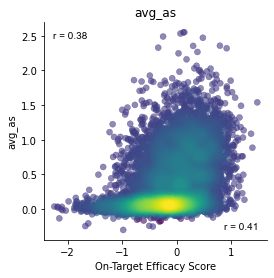

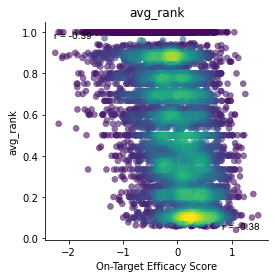

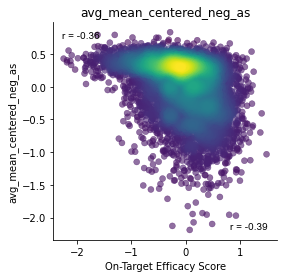

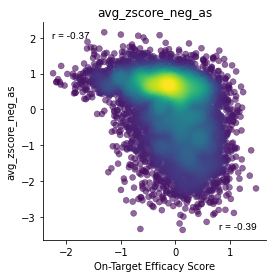

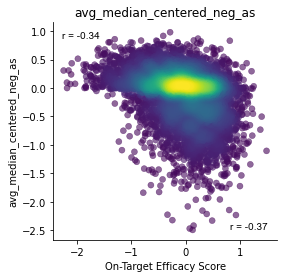

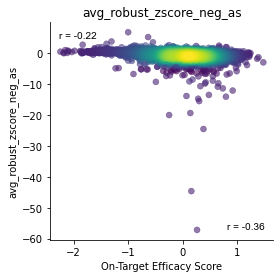

In [29]:
for score in ['avg_as','avg_rank', 'avg_mean_centered_neg_as', 'avg_zscore_neg_as',
              'avg_median_centered_neg_as', 'avg_robust_zscore_neg_as']:
    plt.subplots(figsize=(4,4))
    gpplot.point_densityplot(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                             y=score, x='On-Target Efficacy Score')
    gpplot.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score')
    gpplot.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score', method='spearman', loc='lower right')
    plt.title(score)
    sns.despine()

In [ ]:
sg_avg_rank.to_csv('../data/gilbert_2014/gilbert2014_activity.csv', index=False)